# Comparative Analysis of Leader Tenure in Presidential and Parliamentary Regimes across countries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

**Load Dataset**

In [6]:
leaders_df = pd.read_csv('leaders.csv')
parl_elections_df = pd.read_csv('parl_elections.csv')
pres_elections_df = pd.read_csv('pres_elections.csv')

In [10]:
leaders_df.head()

,country,political_system,leader,start_date,end_date,country_iso3
0,Argentina,presidential,Maria Estela Martinez De Peron,1974-07-01,1976-03-29,ARG
1,Argentina,presidential,Raul Alfonsin,1983-12-10,1989-07-08,ARG
2,Argentina,presidential,Carlos Saul Menem,1989-07-08,1999-12-10,ARG
3,Argentina,presidential,Fernando De La Rua,1999-12-10,2001-12-21,ARG
4,Argentina,presidential,Eduardo Duhalde,2001-12-21,2001-12-23,ARG


In [11]:
parl_elections_df.head()

,iso3c,term_start
0,ALB,1991-03-31
1,ALB,1992-03-22
2,ALB,1996-05-26
3,ALB,1997-06-29
4,ALB,2001-06-24


In [12]:
pres_elections_df.head()

,iso3c,term_start
0,ARM,1997-01-01
1,ARM,1998-04-09
2,ARM,2003-04-09
3,ARM,2008-04-09
4,ARM,2013-04-09


In [50]:
leaders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   country           510 non-null    object        
 1   political_system  510 non-null    object        
 2   leader            510 non-null    object        
 3   start_date        510 non-null    datetime64[ns]
 4   end_date          498 non-null    datetime64[ns]
 5   country_iso3      510 non-null    object        
dtypes: datetime64[ns](2), object(4)
memory usage: 24.0+ KB


In [51]:
parl_elections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   iso3c       1060 non-null   object        
 1   term_start  1060 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 16.7+ KB


In [52]:
pres_elections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   iso3c       376 non-null    object        
 1   term_start  374 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 6.0+ KB


In [53]:
leaders_df.shape 

(510, 6)

In [54]:
parl_elections_df.shape

(1060, 2)

In [55]:
pres_elections_df.shape

(376, 2)

In [13]:
leaders_df['start_date'] = pd.to_datetime(leaders_df['start_date'], errors='coerce')
leaders_df['end_date'] = pd.to_datetime(leaders_df['end_date'], errors='coerce')
parl_elections_df['term_start'] = pd.to_datetime(parl_elections_df['term_start'])
pres_elections_df['term_start'] = pd.to_datetime(pres_elections_df['term_start'])

In [14]:
print("Data Loaded suceessfully")
print(f"Leaders: {len(leaders_df)} records")

Data Loaded suceessfully
Leaders: 510 records


In [15]:
print(f"Parliamentary Elections: {len(parl_elections_df)} records")

Parliamentary Elections: 1060 records


In [16]:
print(f"presidential Elections: {len(pres_elections_df)} records")

presidential Elections: 376 records


In [24]:
def identify_leader_terms(leaders_df, parl_elections_df, pres_elections_df):
    """
    Identify terms for each leader based on elections and 6-month rule.
    """
    all_terms = []
    MIN_TERM_DAYS = 180  # This is for 6 months minimum term days

    # Process each leader one by one
    for idx in range(len(leaders_df)):
        leader_row = leaders_df.iloc[idx]
        
        country_iso = leader_row['country_iso3']  
        leader_name = leader_row['leader']
        country_name = leader_row['country']
        political_system = leader_row['political_system']
        tenure_start = leader_row['start_date']
        tenure_end = leader_row['end_date']
        
        # Step 1: Get the right elections for this country
        if political_system == 'presidential':
            country_elections = pres_elections_df[pres_elections_df['iso3c'] == country_iso]
        else:
            country_elections = parl_elections_df[parl_elections_df['iso3c'] == country_iso]
        
        # Step 2: Find elections during tenure
        elections_during_tenure = []
        for j in range(len(country_elections)):
            election_date = country_elections.iloc[j]['term_start']
            
            if tenure_start < election_date < tenure_end:
                elections_during_tenure.append(election_date)
        
        # Step 3: Create boundaries
        boundaries = [tenure_start] + elections_during_tenure + [tenure_end]
        boundaries = sorted(list(set(boundaries)))
        
        # Step 4: Create raw terms
        raw_terms = []
        for i in range(len(boundaries) - 1):
            term_start = boundaries[i]
            term_end = boundaries[i + 1]
            days = (term_end - term_start).days
            
            raw_terms.append({
                'start': term_start,
                'end': term_end,
                'days': days
            })
        
        # Step 5: Applying 6-month rule by merging terms less than 6 months 
        final_terms = []
        
        if len(raw_terms) == 1:
            final_terms = raw_terms  # Only one term so keep it as is
        else:
            for i in range(len(raw_terms)):
                term = raw_terms[i]
                
                if term['days'] >= MIN_TERM_DAYS:
                    final_terms.append(term)
                else:
                    if i == 0:
                        if i + 1 < len(raw_terms):
                            raw_terms[i + 1]['start'] = term['start']
                            raw_terms[i + 1]['days'] = (raw_terms[i + 1]['end'] - raw_terms[i + 1]['start']).days
                    elif i == len(raw_terms) - 1:
                        if len(final_terms) > 0:
                            final_terms[-1]['end'] = term['end']
                            final_terms[-1]['days'] = (final_terms[-1]['end'] - final_terms[-1]['start']).days
                    else:
                        if len(final_terms) > 0:
                            final_terms[-1]['end'] = term['end']
                            final_terms[-1]['days'] = (final_terms[-1]['end'] - final_terms[-1]['start']).days
        
        if len(final_terms) == 0:
            final_terms = [{
                'start': tenure_start,
                'end': tenure_end,
                'days': (tenure_end - tenure_start).days
            }]    
        
        # Step 6: Create output rows
        for term_number in range(len(final_terms)):
            term = final_terms[term_number]
            
            all_terms.append({
                'Country': country_name,
                'Leader': leader_name,
                'Term start date': term['start'],
                'Term end date': term['end'],
                'Nth term': term_number + 1,  # Will start counting from 1
                'Term duration in days': term['days'],
                'Political system': political_system,
                'Country ISO3': country_iso
            })
    
    return pd.DataFrame(all_terms)

In [25]:
# Generate the terms dataframe
terms_df = identify_leader_terms(leaders_df, parl_elections_df, pres_elections_df)

In [26]:
# sort the output
terms_df = terms_df.sort_values(by=['Country', 'Leader', 'Term start date']).reset_index(drop=True)

In [32]:
print(f"\nTotal terms identified: {len(terms_df)}")
print(f'nSample of results:')
print(terms_df[['Country', 'Leader', 'Term start date', 'Term end date', 'Nth term', 'Term duration in days', 'Political system']])


Total terms identified: 693
nSample of results:
       Country                          Leader Term start date Term end date  \
0    Argentina               Carlos Saul Menem      1989-07-08    1999-12-10   
1    Argentina  Cristina Fernandez De Kirchner      2007-12-10    2015-12-10   
2    Argentina                 Eduardo Duhalde      2001-12-21    2001-12-23   
3    Argentina              Fernando De La Rua      1999-12-10    2001-12-21   
4    Argentina  Maria Estela Martinez De Peron      1974-07-01    1976-03-29   
..         ...                             ...             ...           ...   
688  Venezuela                  Jaime Lusinchi      1984-02-02    1989-02-02   
689  Venezuela            Luis Herrera Campins      1979-03-12    1984-02-02   
690  Venezuela            Nicolas Maduro Moros             NaT    2012-03-05   
691  Venezuela        Rafael Caldera Rodriguez      1969-03-11    1974-03-12   
692  Venezuela        Rafael Caldera Rodriguez      1994-02-02    1999-

In [34]:
#Save the results to a CSV file
output_filename = 'leader_terms_output.csv'
terms_df[['Country', 'Leader', 'Term start date', 'Term end date', 'Nth term', 'Term duration in days']].to_csv(output_filename, index=False)
print(f"\nResults saved to {output_filename}")


Results saved to leader_terms_output.csv


****PART 2****

In [40]:
# Calcultae staistics
leader_summary = terms_df.groupby(['Country', 'Leader', 'Political system']).agg({
    'Nth term': 'max'
}).reset_index()
leader_summary.columns = ['Country', 'Leader', 'Political system', 'Total terms']

# calculate probalities of serving more than one term
analysis = leader_summary.groupby('Political system').agg({
    'Leader': 'count',
    'Total terms': lambda x: (x > 1).sum()
}).reset_index()
analysis.columns = ['Political system', 'Total leaders', 'Leaders with >1 term'] # frleaders with multiple terms
analysis['Probability of >1 term'] = analysis['Leaders with >1 term'] / analysis['Total leaders']
analysis['Percentage'] = analysis['Probability of >1 term'] * 100

print("\nSummary Statistics:")
print(analysis)



Summary Statistics:
  Political system  Total leaders  Leaders with >1 term  \
0    parliamentary            292                   108   
1     presidential            159                    18   

   Probability of >1 term  Percentage  
0                0.369863   36.986301  
1                0.113208   11.320755  


In [42]:
# We can also go further to additional statistics
for system in ['parliamentary', 'presidential']:
    system_data = leader_summary[leader_summary['Political system'] == system]['Total terms']
    print(f"\n{system.upper()} systems:")
    print(f" Total Leaders: {len(system_data)}")
    print(f" Leaders with 1 term: {(system_data == 1).sum()}")
    print(f" Leaders with >1 term: {(system_data > 1).sum()}")
    print(f" Leaders with 2 or more terms: {(system_data > 2).sum()}")
    print(f" Average terms per leader: {system_data.mean():.2f}")
    print(f" Max terms by a leader: {system_data.max()}")


PARLIAMENTARY systems:
 Total Leaders: 292
 Leaders with 1 term: 184
 Leaders with >1 term: 108
 Leaders with 2 or more terms: 42
 Average terms per leader: 1.55
 Max terms by a leader: 5

PRESIDENTIAL systems:
 Total Leaders: 159
 Leaders with 1 term: 141
 Leaders with >1 term: 18
 Leaders with 2 or more terms: 2
 Average terms per leader: 1.13
 Max terms by a leader: 3


DATA VISUALISATION

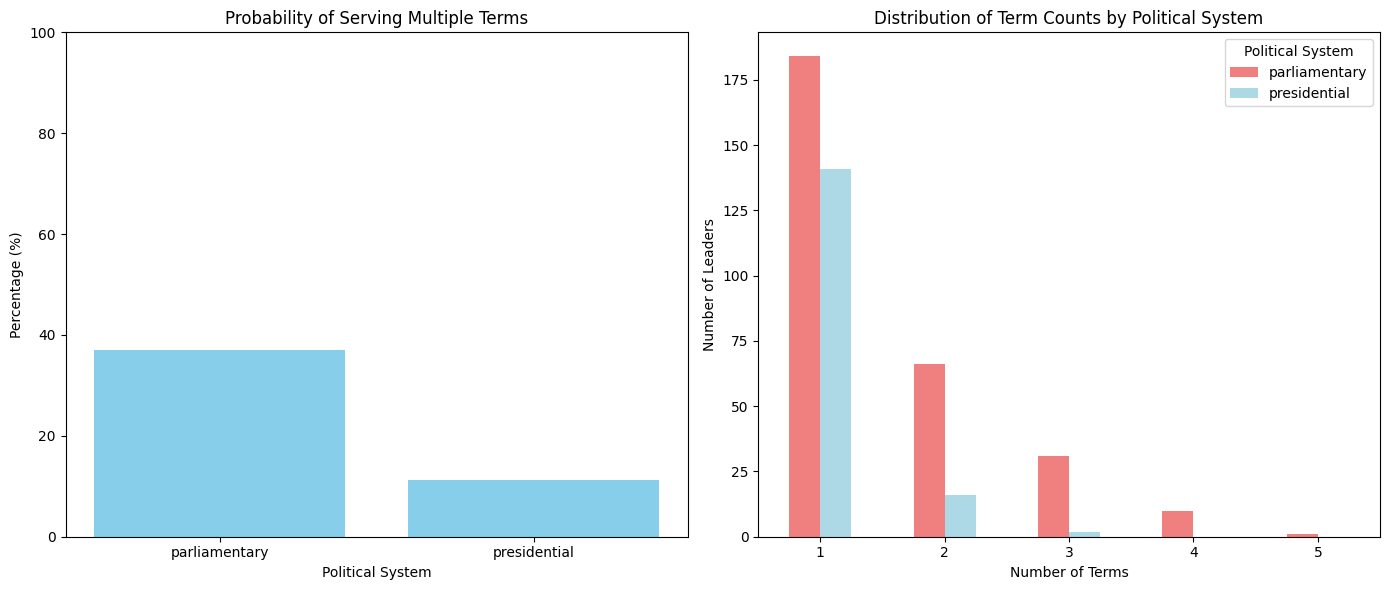

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Chart 1: Probability comparison
axes[0].bar(analysis['Political system'], analysis['Percentage'], color='skyblue')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_xlabel('Political System')
axes[0].set_title('Probability of Serving Multiple Terms')
axes[0].set_ylim(0, 100)

# Chart 2: Distribution
term_chart_data = pd.crosstab(leader_summary['Total terms'], 
                               leader_summary['Political system'])
term_chart_data = term_chart_data.loc[term_chart_data.index <= 5]

term_chart_data.plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightblue'])
axes[1].set_xlabel('Number of Terms')
axes[1].set_ylabel('Number of Leaders')
axes[1].set_title('Distribution of Term Counts by Political System')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].legend(title='Political System')

plt.tight_layout()
plt.savefig('analysis_results.png')
plt.show()

# Key Findings

### Analysis Results - What the Data Shows

### Main Finding

**Parliamentary systems have MORE leaders serving multiple terms than presidential systems.**

- **Parliamentary**: 37% of leaders serve 2 or more terms
- **Presidential**: Only 11% of leaders serve 2 or more terms

This means parliamentary leaders are **3 times more likely** to serve multiple terms.



### Why Does This Happen?

### Term Limits
- **Presidential systems** often have strict term limits. Example: US President can only serve 2 terms maximum. Even if they are very popular, they must stop after 2 terms. Parliamentary systems** usually have NO term limits. A Prime Minister can serve as many terms as they keep winning elections

### Party Support
- In parliamentary systems, if the same party keeps winning elections, the same leader often stays. Example is Angela Merkel (Germany) served 4 terms because her party kept winning. The party decides to keep a successful leader

### How Leaders Get Power
- **Presidential**: The person wins directly. They have a fixed time period (like 4 or 6 years). After their terms are up, they MUST leave
**Parliamentary**: The winning party chooses the leader
- If the party wins again, they often keep the same leader and no forced retirement

### Constitutional Rules
- Many presidential systems wrote rules that say "maximum 2 terms". This was done to prevent one person having too much power for too long. Parliamentary systems focus more on party democracy than individual limits



### What Chart 2 Shows

Looking at the second chart:
- Most leaders (both systems) serve only 1 term but parliamentary leaders have more chances to serve 2, 3, or 4 terms. Also, very few presidential leaders go beyond 2 terms (because of term limits)



### Conclusion

The data shows that **parliamentary systems allow leaders to serve longer** through multiple terms. Presidential systems force more turnover because of constitutional term limits.

This doesn't mean one system is better than the other, they just have different rules about how long leaders can stay in power.